<a href="https://colab.research.google.com/github/AI-Samoyed/COVID-Machine-Learning-/blob/master/COVID_Master_2(Dates).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Packages to install

!pip install geojson
!pip install geopandas

import requests
import folium
import geojson
import geopandas as gpd
import urllib.request
import json
import branca.colormap as cm
from folium.plugins import TimeSliderChoropleth

# General Tools
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# regression functions
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# DATA:
# from "https://resources-covid19canada.hub.arcgis.com/datasets/PHAC-ASPC::covid19-data"
with urllib.request.urlopen("https://opendata.arcgis.com/datasets/a38f44f1a9c14fe1b8352933c71731de_0.geojson") as url:
    data = json.loads(url.read().decode())

# polygon files for the map
map_url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/canada.geojson"
with urllib.request.urlopen(map_url) as url:
    map_data = gpd.read_file(url)

map_data['name'] = map_data['name'].str.replace('Yukon Territory', 'Yukon')

feature_data = pd.read_csv('https://raw.githubusercontent.com/AI-Samoyed/COVID-Machine-Learning-/master/feature2')

In [2]:
raw = pd.DataFrame.from_dict(data["features"])
raw = pd.DataFrame.from_records(raw["properties"])
feature_data

Province_Name       Pop  ...  Med_Income  Avg_CD
0                      CANADA  35151728  ...       34204    26.2
1   Newfoundland and Labrador    519716  ...       31754    20.5
2        Prince Edward Island    142907  ...       31744    18.0
3                 Nova Scotia    923598  ...       31813    22.2
4               New Brunswick    747101  ...       30961    18.9
5                      Quebec   8164361  ...       32975    25.8
6                     Ontario  13448494  ...       33539    28.8
7                    Manitoba   1278365  ...       34188    22.4
8                Saskatchewan   1098352  ...       38299    18.8
9                     Alberta   4067175  ...       42717    25.0
10           British Columbia   4648055  ...       33012    25.9
11                      Yukon     35874  ...       45804    16.5
12      Northwest Territories     41786  ...       50618    12.9
13                    Nunavut     35944  ...       29743    10.0

[14 rows x 11 columns]

In [3]:
def model_with_RF(train_data,test_data,start_date):
    """ Model data using RandomForest Regressor. """
    x_train, y_train = split_xy(train_data)
    x_test, y_test = split_xy(test_data)
    
    model = RandomForestRegressor(n_estimators = 100, random_state = 0)
    model.fit(x_train,y_train)
    
    y_preds = model.predict(x_test)
    date_range = pd.date_range(start=start_date, end=pd.to_datetime("today"), periods=(len(y_preds)))

    df = pd.DataFrame({"Date": date_range, "Actual":y_test,"Preds":y_preds})
    df['Date'] = df['Date'].dt.date

    #print(np.mean(np.abs(y_preds-y_test))) # mean absolute error
    #print(np.mean(np.power(y_preds-y_test,2))) # mean squared error

    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    #plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    #plt.plot(df['Date'], df['Preds'], label='preds', lw=2, marker='o')
    #plt.plot(df['Date'], df['Actual'], label='actual', lw=2, marker='s')  
    #plt.gcf().autofmt_xdate()
    #plt.legend()
    return df
    


def model_with_LR(train_data,test_data,start_date):
    """ Model data using LinearRegressor. """
    x_train, y_train = split_xy(train_data)
    x_test, y_test = split_xy(test_data)
    
    model = LinearRegression()
    model.fit(x_train,y_train)
    
    y_preds = model.predict(x_test)
    date_range = pd.date_range(start=start_date, end=pd.to_datetime("today"), periods=(len(y_preds)))
    
    df = pd.DataFrame({"Date": date_range, "Actual":y_test,"Preds":y_preds})
    df['Date'] = df['Date'].dt.date

    #print(np.mean(np.abs(y_preds-y_test))) # mean absolute error
    #print(np.mean(np.power(y_preds-y_test,2))) # mean squared error

    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    #plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    #plt.plot(df['Date'], df['Preds'], label='preds', lw=2, marker='o')
    #plt.plot(df['Date'], df['Actual'], label='actual', lw=2, marker='s')  
    #plt.gcf().autofmt_xdate()
    #plt.legend()
    return df
    print(np.mean(np.abs(y_preds-y_test))) # mean absolute error
    print(np.mean(np.power(y_preds-y_test,2))) # mean squared error


    
    

In [4]:
def create_rolling_window(data, window_size=7):
    """ 
        Create a window from time A to B where each entry in the window is the
        number of new cases on that day.
    """
    #data = data[data > 0] # remove days missing data
    ws = window_size + 1
    x_data = data[:-1]
    
    x_data = np.reshape(x_data, (-1,1))
    temp_data = np.roll(x_data, -1)
    for x in range(1, ws):
        # Stack
        x_data = np.concatenate((x_data[:-1], temp_data[:-1]), 1)
        # Step, roll left by 1
        temp_data = np.roll(temp_data, -1)[:-1]
    
    cols = ["day{}".format(i) for i in range(1,ws)] + ['newDay']
    return pd.DataFrame(x_data, columns=cols)

def create_rolling_window2(data, window_size=7):
    """ 
        Create a window from time A to B where each entry in the window is the
        number of new cases on that day.
    """
    #data = data[data > 0] # remove days missing data
    case = data["Cases_Today"]
    date = data['Date'][7:-1]
    newdates = pd.DataFrame(date).reset_index(drop=True)
    data = case.values
    
    ws = window_size + 1
    

    x_data = data[:-1]
    x_data = np.reshape(x_data, (-1,1))
    temp_data = np.roll(x_data, -1)
    for x in range(1, ws):
        # Stack
        x_data = np.concatenate((x_data[:-1], temp_data[:-1]), 1)
        # Step, roll left by 1
        temp_data = np.roll(temp_data, -1)[:-1]
    
    cols = ["day{}".format(i) for i in range(1,ws)] + ['newDay']

    result = pd.DataFrame(x_data, columns=cols)
    return pd.concat([result,newdates], axis = 1)   

def split_train_test(data):
    """
        Divide into train,test,val sets
        Take first 70% as train and next 30% as test
    """
    ntrain,ntest = int(len(data) * 0.7), int(len(data) * 0.1)
    data = data.sample(frac=1)
    
    train = data[:ntrain].reset_index(drop=True)
    test = data[ntrain:].reset_index(drop=True)
    return train, test

def add_features(df,features):
    """ Append feature data to every row of df. """
    df['merger'] = 1
    features['merger'] = 1
    
    df = df.merge(features, how='outer', on='merger').drop(['merger','Province_Name'], axis=1)
    return df

def prepare_data(covid_df, features):
    """ Process of creating the final training and test sets from initial data. """
    rw = create_rolling_window(covid_df.values)
    rw_with_features = add_features(rw,features)
    
    return split_train_test(rw_with_features)

def split_xy(data):
    """ Separate training features and training output. """
    return data[data.columns.difference(['newDay'])], data['newDay']

In [5]:
def roll_days(df):
    """ Shift all case data one day to the left. """
    day = 'day{}'
    for i in range(1,7):
        df[day.format(i)] = df[day.format(i+1)]
        
    return df
        
def forecast(case_data, feature_data, days=7):
    """ Recursively predict the next 'days' by including the last prediction. """
    forecast_train_data = case_data[:-days]
    forecast_test_data = case_data[-days:].reset_index(drop=True)
    
    rw = create_rolling_window2(forecast_train_data.values)
    rw_plus_features = add_features(rw,feature_data)
    forecast_start = rw_plus_features[-1:]
    X,Y = split_xy(rw_plus_features)
    
    model = LinearRegression()
    model.fit(X,Y)
    
    forecast_start = roll_days(forecast_start)
    forecast_start['day7'] = forecast_start['newDay']
    forecast_start, _ = split_xy(forecast_start) # drop the 'newDay' column

    dcols = ['day1','day2','day3','day4','day5','day6','day7',]
    predictions = []
    for i in range(days):
        predictions.append(round(model.predict(forecast_start)[0]))
        forecast_start = roll_days(forecast_start)
        forecast_start['day7'] = predictions[-1]
        
    print(predictions)
    print(forecast_test_data)
    print(np.mean(np.abs(predictions-forecast_test_data))) # mean absolute error
    print(np.mean(np.power(predictions-forecast_test_data,2))) # mean squared error
    
    plt.plot(predictions, label='preds')
    plt.plot(forecast_test_data, label='actual')
    plt.legend()

In [6]:
def makemap(dataframe):
  cmap = cm.linear.YlOrRd_09.scale(0, max(dataframe['Preds']))
  dataframe['colour'] = dataframe['Preds'].map(cmap)
  prov_list = dataframe['name'].unique().tolist()
  prov_idx = range(len(prov_list))

  style_dict = {}
  for i in prov_idx:
      prov = prov_list[i]
      result = dataframe[dataframe['name'] == prov]
      inner_dict = {}
      for _, r in result.iterrows():
          inner_dict[r['Date']] = {'color': r['colour'], 'opacity': 0.7}
      style_dict[str(i)] = inner_dict
    
  prov_df = dataframe[['geometry']]
  prov_gdf = gpd.GeoDataFrame(prov_df)
  prov_gdf = prov_gdf.drop_duplicates().reset_index()
  return prov_gdf,  style_dict, cmap

In [7]:
raw_test = raw.copy()
raw_exclude = (raw_test['Name'] != "Canada") & (raw_test['Name'] != "Repatriated travellers")
raw_test = raw_test.loc[raw_exclude]

prov_names = (raw_test["Name"].unique()).tolist()
start_date='2020/03/11'
raw_test = raw_test[raw_test["Date"] >= start_date]
raw_test

PRUID                       Name  ... Percent_Death Percent_Active
57       61      Northwest Territories  ...           NaN            NaN
58       62                    Nunavut  ...           NaN            NaN
59       11       Prince Edward Island  ...           NaN            NaN
62       60                      Yukon  ...           NaN            NaN
63       12                Nova Scotia  ...           NaN            NaN
...     ...                        ...  ...           ...            ...
3950     35                    Ontario  ...          3.29          11.85
3951     47               Saskatchewan  ...          0.53          42.74
3952     48                    Alberta  ...          0.98          27.01
3953     59           British Columbia  ...          1.28          30.60
3955     10  Newfoundland and Labrador  ...          1.23           7.72

[3380 rows x 20 columns]

# **Actual Case Today**

In [8]:
def makemap_org(dataframe):
  cmap = cm.linear.YlOrRd_09.scale(0, max(dataframe['Cases_Today']))
  dataframe['colour'] = dataframe['Cases_Today'].map(cmap)
  prov_list = dataframe['name'].unique().tolist()
  prov_idx = range(len(prov_list))

  style_dict = {}
  for i in prov_idx:
      prov = prov_list[i]
      result = dataframe[dataframe['name'] == prov]
      inner_dict = {}
      for _, r in result.iterrows():
          inner_dict[r['Date']] = {'color': r['colour'], 'opacity': 0.7}
      style_dict[str(i)] = inner_dict
    
  prov_df = dataframe[['geometry']]
  prov_gdf = gpd.GeoDataFrame(prov_df)
  prov_gdf = prov_gdf.drop_duplicates().reset_index()
  return prov_gdf,  style_dict, cmap

raw_test_df = raw_test.copy()
raw_test_df = raw_test_df.rename(columns={'Name': 'name'})

raw_test_df ['Date'] = pd.to_datetime(raw_test_df['Date']).astype(int) / 10**9
raw_test_df ['Date'] = raw_test_df['Date'].astype(int).astype(str)
raw_test_df = raw_test_df[["name", "Date", "Cases_Today"]]

raw_map_df = raw_test_df.merge(map_data, on='name')
raw_map_df = raw_map_df[['name', 'Date', 'Cases_Today', 'geometry']]
raw_map_df #the input dataframe must look like this

raw_prov_gdf, raw_style_dict, raw_cmap= makemap_org(raw_map_df)

### Map Part

raw_map = folium.Map(location=[56.1304, -106.3468], 
                     zoom_start=2.5, min_zoom=2, width=1000, height=500, max_bounds=True)

_ = TimeSliderChoropleth(
      data=raw_prov_gdf.to_json(),
      styledict=raw_style_dict,
  ).add_to(raw_map)

_ = raw_cmap.add_to(raw_map)

raw_cmap.caption = "Actual Case Today"

folium.LayerControl().add_to(raw_map)

raw_map

# **Random Forest**

In [9]:
def all_prov_RF(names, main_data, feature_data, start_date):
  main_result = pd.DataFrame({})

  for prov_name in names:
    print(f"working on {prov_name}")
    cur_covid = main_data[main_data['Name'] == prov_name]
    cur_covid = cur_covid[(cur_covid['Date'] > start_date )] 
    cols = ['Date', 'Name', 'Cases_Today']
    cur_covid = cur_covid[cols].reset_index()
    cur_covid_processed = cur_covid[cur_covid['Name'] == prov_name]['Cases_Today'].reset_index(drop=True)
    feature_set = feature_data[feature_data['Province_Name'] == prov_name]
    prov_train, prov_test = prepare_data(cur_covid_processed, feature_set)
    prov_result = model_with_RF(prov_train,prov_test,start_date)
    prov_result['name']=prov_name
    main_result = pd.concat([main_result, prov_result], axis=0)
  
  return main_result

all_prov_RF = all_prov_RF(prov_names, raw_test, feature_data, start_date)
all_prov_RF

working on Ontario


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


working on British Columbia


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


working on Quebec
working on Alberta


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


working on Northwest Territories
working on Nunavut


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


working on Prince Edward Island
working on Yukon


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


working on Nova Scotia
working on New Brunswick


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


working on Saskatchewan
working on Newfoundland and Labrador


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


working on Manitoba


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Date  Actual    Preds      name
0   2020-03-11     106    94.17   Ontario
1   2020-03-14     100   102.66   Ontario
2   2020-03-18     566   571.61   Ontario
3   2020-03-22     179   211.26   Ontario
4   2020-03-25    1487  1403.93   Ontario
..         ...     ...      ...       ...
71  2020-11-28      17    16.59  Manitoba
72  2020-12-02       2     7.37  Manitoba
73  2020-12-05       9     5.09  Manitoba
74  2020-12-09       0     0.96  Manitoba
75  2020-12-13       2     3.46  Manitoba

[988 rows x 4 columns]

In [10]:
RF_test_df = all_prov_RF.copy()

RF_test_df ['Date'] = pd.to_datetime(RF_test_df['Date']).astype(int) / 10**9
RF_test_df ['Date'] = RF_test_df['Date'].astype(int).astype(str)
RF_test_df = RF_test_df[["name", "Date", "Preds"]]

RF_map_df = RF_test_df.merge(map_data, on='name')
RF_map_df = RF_map_df[['name', 'Date', 'Preds', 'geometry']]
RF_map_df #the input dataframe must look like this

RF_prov_gdf, RF_style_dict, RF_cmap= makemap(RF_map_df)

### Map Part


RF_map = folium.Map(location=[56.1304, -106.3468], 
                     zoom_start=2.5, min_zoom=2, width=1000, height=500, max_bounds=True)

_ = TimeSliderChoropleth(
      data=RF_prov_gdf.to_json(),
      styledict=RF_style_dict,
  ).add_to(RF_map)

_ = RF_cmap.add_to(RF_map)

RF_cmap.caption = "RF Pred Today"

folium.LayerControl().add_to(RF_map)

RF_map

# **Linear Regression**

In [11]:
def all_prov_LR(names, main_data, feature_data, start_date):
  main_result = pd.DataFrame({})

  for prov_name in names:
    print(f"working on {prov_name}")
    cur_covid = main_data[main_data['Name'] == prov_name]
    cur_covid = cur_covid[(cur_covid['Date'] > start_date )] 
    cols = ['Date', 'Name', 'Cases_Today']
    cur_covid = cur_covid[cols].reset_index()
    cur_covid_processed = cur_covid[cur_covid['Name'] == prov_name]['Cases_Today'].reset_index(drop=True)
    feature_set = feature_data[feature_data['Province_Name'] == prov_name]
    prov_train, prov_test = prepare_data(cur_covid_processed, feature_set)
    prov_result = model_with_LR(prov_train,prov_test,start_date)
    prov_result['name']=prov_name
    main_result = pd.concat([main_result, prov_result], axis=0)
  
  return main_result

all_prov_LR = all_prov_LR(prov_names, raw_test, feature_data, start_date)
all_prov_LR

working on Ontario
working on British Columbia
working on Quebec
working on Alberta
working on Northwest Territories
working on Nunavut
working on Prince Edward Island
working on Yukon


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

working on Nova Scotia
working on New Brunswick
working on Saskatchewan
working on Newfoundland and Labrador
working on Manitoba


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Date  Actual        Preds      name
0   2020-03-11    1581  1496.163372   Ontario
1   2020-03-14     106    80.539058   Ontario
2   2020-03-18     157   171.417458   Ontario
3   2020-03-22     165   147.414491   Ontario
4   2020-03-25     119   152.795022   Ontario
..         ...     ...          ...       ...
71  2020-11-28      18    23.139580  Manitoba
72  2020-12-02       5     4.290866  Manitoba
73  2020-12-05     383   222.120177  Manitoba
74  2020-12-09       0     4.208253  Manitoba
75  2020-12-13       2     5.239728  Manitoba

[988 rows x 4 columns]

In [12]:
LR_test_df = all_prov_LR.copy()

LR_test_df ['Date'] = pd.to_datetime(LR_test_df['Date']).astype(int) / 10**9
LR_test_df ['Date'] = LR_test_df['Date'].astype(int).astype(str)
LR_test_df = LR_test_df[["name", "Date", "Preds"]]

LR_map_df = LR_test_df.merge(map_data, on='name')
LR_map_df = LR_map_df[['name', 'Date', 'Preds', 'geometry']]
LR_map_df #the input dataframe must look like this

LR_prov_gdf, LR_style_dict, LR_cmap= makemap(RF_map_df)

### Map Part

LR_map = folium.Map(location=[56.1304, -106.3468], 
                     zoom_start=2.5, min_zoom=2, width=1000, height=500, max_bounds=True)

_ = TimeSliderChoropleth(
      data=LR_prov_gdf.to_json(),
      styledict=LR_style_dict,
  ).add_to(LR_map)

_ = LR_cmap.add_to(LR_map)

LR_cmap.caption = "LR Pred Today"

folium.LayerControl().add_to(LR_map)

LR_map

# **# Random Forrest and Linear Regression with Dates**

In [13]:
def create_rolling_window2(data, window_size=7):
    """ 
        Create a window from time A to B where each entry in the window is the
        number of new cases on that day.
    """
    #data = data[data['Cases_Today'] > 0] # remove days missing data
    prov_name = data["Name"]
    case = data["Cases_Today"]
    date = data['Date'][window_size:-1]
    newdates = pd.DataFrame(date).reset_index(drop=True)
    data = case.values
    
    ws = window_size + 1
    

    x_data = data[:-1]
    x_data = np.reshape(x_data, (-1,1))
    temp_data = np.roll(x_data, -1)
    for x in range(1, ws):
        # Stack
        x_data = np.concatenate((x_data[:-1], temp_data[:-1]), 1)
        # Step, roll left by 1
        temp_data = np.roll(temp_data, -1)[:-1]
    
    cols = ["day{}".format(i) for i in range(1,ws)] + ['newDay']

    result = pd.DataFrame(x_data, columns=cols)
    result = pd.concat([result,newdates], axis = 1)
    result['Name'] = prov_name 
    return result

def forecast2(case_data, feature_data, days=7):
    """ Recursively predict the next 'days' by including the last prediction. """
    forecast_train_data = case_data[:-days]
    forecast_test_data = case_data[-days:].reset_index(drop=True)
    
    rw = create_rolling_window2(forecast_train_data)
    prov_name = rw["Name"][0]
    cur_Prov = feature_data[feature_data['Province_Name'] == prov_name]
    rw_plus_features = add_features(rw,cur_Prov)


    forecast_start = rw_plus_features[-1:]
    X,Y= split_xy(rw_plus_features)
    D = X["Date"]
    X = X.drop(['Date','Name'], axis=1)

    #print(X.to_string())
    model = LinearRegression()
    model.fit(X,Y)
    
    forecast_start = roll_days(forecast_start)
    forecast_start['day7'] = forecast_start['newDay']
    forecast_start, _  = split_xy(forecast_start) # drop the 'newDay' column
    forecast_date = forecast_start["Date"]
    forecast_start = forecast_start.drop(['Date','Name'], axis=1)
    forecast_test_date = forecast_test_data['Date']
    forecast_test_data = forecast_test_data.drop(['Date','Name'], axis=1)
    forecast_test_data = forecast_test_data.values

    dcols = ['day1','day2','day3','day4','day5','day6','day7',]
    predictions = []
    predictions_date = []
    for i in range(days):
        predictions.append(round(model.predict(forecast_start)[0]))
        predictions_date.append(forecast_date)
        forecast_start = roll_days(forecast_start)
        forecast_start['day7'] = predictions[-1]
    
    tab_pred = pd.DataFrame(predictions)
    tab_test = pd.DataFrame(forecast_test_data)
    result = pd.concat([forecast_test_date, tab_pred, tab_test], axis=1)
    column_name = ['Date', 'Preds', 'Acutal']
    result.columns = column_name
    print(result)
    print(np.mean(np.abs(predictions-forecast_test_data))) # mean absolute error
    print(np.mean(np.power(predictions-forecast_test_data,2))) # mean squared error
    
    
    plt.plot(predictions, label='preds')
    plt.plot(forecast_test_data, label='actual')
    plt.legend()

def split_train_test2(data):
    """
        Divide into train,test,val sets
        Take first 70% as train and next 30% as test
    """
    ntrain,ntest = int(len(data) * 0.7), int(len(data) * 0.1)
    data = data.sample(frac=1)
    
    train = data[:ntrain].reset_index(drop=True)
    test = data[ntrain:].reset_index(drop=True)
    return train, test

def prepare_data2(covid_df, features):
    """ Process of creating the final training and test sets from initial data. """
    rw = create_rolling_window2(covid_df)
    return split_train_test(rw)

def split_xy2(data):
    """ Separate training features and training output. """
    NewDay = data['newDay']
    Dates = data['Date']
    Rest = data.drop(['Date','Name'], axis=1)
    return Rest, NewDay, Dates

def model_with_RF2(train_data,test_data):
    """ Model data using RandomForest Regressor. """
    x_train, y_train, date_train = split_xy2(train_data)
    x_test, y_test, date_test = split_xy2(test_data)
    
    model = RandomForestRegressor(n_estimators = 100, random_state = 0)
    model.fit(x_train,y_train)
    
    y_preds = model.predict(x_test)

    tab_pred = pd.DataFrame(y_preds)
    tab_test = pd.DataFrame(y_test)
    tab_dates = pd.DataFrame(date_test)

    column_name = ['Date', 'Preds', 'Actual']
    df = pd.concat([tab_dates, tab_pred, tab_test], axis=1)
    df.columns = column_name
    df = df.sort_values(by='Date',ascending=True)
    df = df.reset_index(drop=True)

    #print(np.mean(np.abs(y_preds-y_test))) # mean absolute error
    #print(np.mean(np.power(y_preds-y_test,2))) # mean squared error
    #print(df)
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    #plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    #plt.plot(df['Date'], df['Actual'], label='actual', lw=2, marker='s') 
    #plt.plot(df['Date'], df['Preds'], label='preds', lw=2, marker='o')
    #plt.gcf().autofmt_xdate()
    #plt.legend()
    return df
  
def model_with_LR2(train_data,test_data):
    """ Model data using LinearRegressor. """
    x_train, y_train, date_train = split_xy2(train_data)
    x_test, y_test, date_test = split_xy2(test_data)
    
    model = LinearRegression()
    model.fit(x_train,y_train)
    
    y_preds = model.predict(x_test)
    tab_pred = pd.DataFrame(y_preds)
    tab_test = pd.DataFrame(y_test)
    tab_dates = pd.DataFrame(date_test)    
    column_name = ['Date', 'Preds', 'Actual']
    df = pd.concat([tab_dates, tab_pred, tab_test], axis=1)
    df.columns = column_name
    df = df.sort_values(by='Date',ascending=True)
    df = df.reset_index(drop=True)

    #print(np.mean(np.abs(y_preds-y_test))) # mean absolute error
    #print(np.mean(np.power(y_preds-y_test,2))) # mean squared error
    #print(df)
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    #plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    #plt.plot(df['Date'], df['Actual'], label='actual', lw=2, marker='s') 
    #plt.plot(df['Date'], df['Preds'], label='preds', lw=2, marker='o')
    #plt.gcf().autofmt_xdate()
    #plt.legend()
    return df

In [14]:
main_data = raw.copy()
cur_covid = main_data[main_data['Name'] == 'Ontario']
cur_covid = cur_covid[(cur_covid['Date'] > start_date )] 
cols = ['Date', 'Name', 'Cases_Today']
cur_covid = cur_covid[cols].reset_index()
cur_covid_processed = cur_covid[cur_covid['Name'] == 'Ontario']['Cases_Today'].reset_index(drop=True)
feature_set = feature_data[feature_data['Province_Name'] == 'Ontario']
test = cur_covid.drop(['index'], axis=1)

In [15]:
t_train, t_test = prepare_data2(test, feature_data)
model_with_LR2(t_train,t_test)

Date   Preds  Actual
0   2020/03/20 12:00:00+00    53.0      53
1   2020/03/25 12:00:00+00   100.0     100
2   2020/03/27 12:00:00+00   135.0     135
3   2020/03/31 12:00:00+00   260.0     260
4   2020/04/02 12:00:00+00   401.0     401
..                     ...     ...     ...
71  2020/11/15 12:00:00+00  1248.0    1248
72  2020/11/16 12:00:00+00  1487.0    1487
73  2020/11/21 12:00:00+00  1588.0    1588
74  2020/11/22 12:00:00+00  1534.0    1534
75  2020/11/23 12:00:00+00  1589.0    1589

[76 rows x 3 columns]

In [16]:
model_with_RF2(t_train,t_test)

Date    Preds  Actual
0   2020/03/20 12:00:00+00    54.38      53
1   2020/03/25 12:00:00+00    95.92     100
2   2020/03/27 12:00:00+00   132.90     135
3   2020/03/31 12:00:00+00   251.98     260
4   2020/04/02 12:00:00+00   400.63     401
..                     ...      ...     ...
71  2020/11/15 12:00:00+00  1281.29    1248
72  2020/11/16 12:00:00+00  1503.60    1487
73  2020/11/21 12:00:00+00  1508.99    1588
74  2020/11/22 12:00:00+00  1534.87    1534
75  2020/11/23 12:00:00+00  1531.21    1589

[76 rows x 3 columns]

In [17]:
raw2 = raw_test.copy()
raw2 = raw2[['Name','Date','Cases_Today']]
raw2['Date'] = pd.to_datetime(raw2['Date'], infer_datetime_format=True)

def all_prov_RF2(names, main_data, feature_data, start_date):
  main_result = pd.DataFrame({})

  for prov_name in names:
    print(f"working on {prov_name}")
    cur_covid = main_data[main_data['Name'] == prov_name]
    cur_covid = cur_covid[cur_covid['Date'] > start_date]
    feature_set = feature_data[feature_data['Province_Name'] == prov_name]
    prov_train, prov_test = prepare_data2(cur_covid, feature_set)
    prov_result = model_with_RF2(prov_train,prov_test)
    prov_result['name']=prov_name
    prov_result = prov_result.reset_index(drop=True)
    main_result = pd.concat([main_result, prov_result], axis=0)
  return main_result

def all_prov_LR2(names, main_data, feature_data, start_date):
  main_result = pd.DataFrame({})

  for prov_name in names:
    print(f"working on {prov_name}")
    cur_covid = main_data[main_data['Name'] == prov_name]
    cur_covid = cur_covid[cur_covid['Date'] > start_date]
    cur_covid = cur_covid.reset_index(drop=True)
    feature_set = feature_data[feature_data['Province_Name'] == prov_name]
    prov_train, prov_test = prepare_data2(cur_covid, feature_set)
    prov_result = model_with_LR2(prov_train,prov_test)
    prov_result['name']=prov_name
    prov_result = prov_result.reset_index(drop=True)
    main_result = pd.concat([main_result, prov_result], axis=0)
  
  return main_result

In [18]:
all_prov_RF2 = all_prov_RF2(prov_names, raw2, feature_data, start_date)

working on Ontario
working on British Columbia
working on Quebec
working on Alberta
working on Northwest Territories
working on Nunavut
working on Prince Edward Island
working on Yukon
working on Nova Scotia
working on New Brunswick
working on Saskatchewan
working on Newfoundland and Labrador
working on Manitoba


In [19]:
RF2_n = all_prov_RF2.copy()

RF2_n['Date'] = pd.to_datetime(RF2_n['Date']).astype(int) / 10**9
RF2_n['Date'] = RF2_n['Date'].astype(int).astype(str)

RF2_n_map_df = RF2_n.merge(map_data, on='name')
RF2_n_map_df = RF2_n_map_df[['name', 'Date', 'Preds', 'geometry']]

RF2_n_prov_gdf, RF2_n_style_dict, RF2_n_cmap= makemap(RF2_n_map_df)

### Map Part

RF2_n_map = folium.Map(location=[56.1304, -106.3468], 
                     zoom_start=2.5, min_zoom=2, width=1000, height=500, max_bounds=True)

_ = TimeSliderChoropleth(
      data=RF2_n_prov_gdf.to_json(),
      styledict=RF2_n_style_dict,
  ).add_to(RF2_n_map)

_ = RF2_n_cmap.add_to(RF2_n_map)

RF2_n_cmap.caption = "Random Forest Pred Today"

folium.LayerControl().add_to(RF2_n_map)

RF2_n_map


In [20]:
all_prov_LR2 = all_prov_LR2(prov_names, raw2, feature_data, start_date)

LF2_n = all_prov_LR2.copy()

LF2_n['Date'] = pd.to_datetime(LF2_n['Date']).astype(int) / 10**9
LF2_n['Date'] = LF2_n['Date'].astype(int).astype(str)

LF2_n_map_df = LF2_n.merge(map_data, on='name')
LF2_n_map_df = LF2_n_map_df[['name', 'Date', 'Preds', 'geometry']]

LF2_n_prov_gdf, LF2_n_style_dict, LF2_n_cmap= makemap(LF2_n_map_df)

### Map Part

LF2_n_map = folium.Map(location=[56.1304, -106.3468], 
                     zoom_start=2.5, min_zoom=2, width=1000, height=500, max_bounds=True)

_ = TimeSliderChoropleth(
      data=LF2_n_prov_gdf.to_json(),
      styledict=LF2_n_style_dict,
  ).add_to(LF2_n_map)

_ = LF2_n_cmap.add_to(LF2_n_map)

LF2_n_cmap.caption = "Linear Regression Pred Today"

folium.LayerControl().add_to(LF2_n_map)

LF2_n_map

working on Ontario
working on British Columbia
working on Quebec
working on Alberta
working on Northwest Territories
working on Nunavut
working on Prince Edward Island
working on Yukon
working on Nova Scotia
working on New Brunswick
working on Saskatchewan
working on Newfoundland and Labrador
working on Manitoba


In [21]:
print(all_prov_LR2.to_string())

                  Date         Preds  Actual                       name
0  2020-03-18 12:00:00  1.200000e+01      12                    Ontario
1  2020-03-20 12:00:00  5.300000e+01      53                    Ontario
2  2020-03-24 12:00:00  8.500000e+01      85                    Ontario
3  2020-03-31 12:00:00  2.600000e+02     260                    Ontario
4  2020-04-02 12:00:00  4.010000e+02     401                    Ontario
5  2020-04-03 12:00:00  4.620000e+02     462                    Ontario
6  2020-04-08 12:00:00  5.500000e+02     550                    Ontario
7  2020-04-09 12:00:00  4.830000e+02     483                    Ontario
8  2020-04-12 12:00:00  4.010000e+02     401                    Ontario
9  2020-04-14 12:00:00  4.830000e+02     483                    Ontario
10 2020-04-16 12:00:00  5.140000e+02     514                    Ontario
11 2020-04-17 12:00:00  5.640000e+02     564                    Ontario
12 2020-04-18 12:00:00  4.850000e+02     485                    

# **LTSM**

In [22]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

def lstm_simple(data, start_date_select='2020-3-11', no_zero = 1, n_days_in = 14, n_days_out = 1):

  '''
  Input:

  Output:
  result: dataframe including all provinces
  '''
  def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out
      # check if we are beyond the sequence
      if out_end_ix > len(sequence):
        break
      # gather input and output parts of the pattern
      seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
      X.append(seq_x)
      y.append(seq_y)
    return np.array(X), np.array(y)
  
  data = data[["Name", "Date", "Cases_Today", "RecoveredToday", "TestedToday"]]
  raw_main = data.copy()

  pd.DataFrame.from_records(raw_main)

  #get all province name
  prov_names = (raw_main["Name"].unique()).tolist()

  #collect all province in main_result
  main_result = pd.DataFrame({})

  for prov_name in prov_names:
    raw = raw_main[raw_main["Name"] == prov_name]
    print(f"working on {prov_name}")
    # select based on date and excluding zeros or not
    start_date = (data['Date'] >= start_date_select)
    raw = raw.loc[start_date]

    if (no_zero == 1):
      no_zero_row = (raw['Cases_Today'] != 0)
      raw = raw.loc[no_zero_row]
    
    raw_seq = raw['Cases_Today'].tolist()
    date_seq = raw['Date'].tolist()

    # choose a number of time steps
    n_steps_in, n_steps_out = n_days_in, n_days_out
    # split into samples
    X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # define model
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X, y, epochs=50, verbose=0)
    # demonstrate prediction
    result = []
    date_list = []
    for i in range(len(raw_seq) - n_steps_in):
      x_input = np.array(raw_seq[i:i+n_steps_in])
      x_input = x_input.reshape((1, n_steps_in, n_features))
      yhat = model.predict(x_input, verbose=0)
      result.append(yhat.item())
      date_list.append(date_seq[i+n_steps_in])
      #print(x_input, date_seq[i+n_steps_in], yhat.item())
    result = [round(x) for x in result]

    df_test = pd.DataFrame({'Date': date_list, 'Preds': result}) 
    start_date_select_df = (pd.to_datetime(start_date_select) + pd.DateOffset(days=n_steps_in))
    df_true = raw.loc[raw['Date'] >= start_date_select_df.strftime('%Y-%m-%d')]
    df_combine = (df_true.merge(df_test, left_index=False, right_index=False, how='inner'))
    df_combine['Difference'] = df_combine['Preds'] - df_combine['Cases_Today']

    main_result = pd.concat([main_result, df_combine], axis=0)

  return main_result

In [23]:
test_lstm = lstm_simple(raw_test, start_date_select='2020-3-11', no_zero = 0, n_days_in = 7, n_days_out = 1)
test_lstm

working on Northwest Territories
working on Nunavut
working on Prince Edward Island
working on Yukon
working on Nova Scotia
working on Ontario
working on New Brunswick
working on British Columbia
working on Alberta
working on Saskatchewan
working on Newfoundland and Labrador
working on Quebec
working on Manitoba


Name                    Date  ...  Preds  Difference
0    Northwest Territories  2020/03/18 12:00:00+00  ...      0           0
1    Northwest Territories  2020/03/19 12:00:00+00  ...      0           0
2    Northwest Territories  2020/03/20 12:00:00+00  ...      0           0
3    Northwest Territories  2020/03/21 12:00:00+00  ...      0          -1
4    Northwest Territories  2020/03/22 12:00:00+00  ...      0           0
..                     ...                     ...  ...    ...         ...
248               Manitoba  2020/11/21 12:00:00+00  ...    340         -45
249               Manitoba  2020/11/22 12:00:00+00  ...    365         125
250               Manitoba  2020/11/23 12:00:00+00  ...    440        -103
251               Manitoba  2020/11/24 12:00:00+00  ...    392         -79
252               Manitoba  2020/11/25 12:00:00+00  ...    382          33

[3289 rows x 7 columns]

64.44664031620553
11052.193675889328


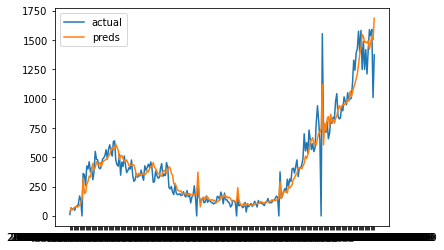

In [24]:
lstm_ontario = test_lstm.copy()
lstm_ontario = lstm_ontario[lstm_ontario['Name']=='Ontario']

print(np.mean(np.abs(lstm_ontario['Preds']-lstm_ontario['Cases_Today']))) # mean absolute error
print(np.mean(np.power(lstm_ontario['Preds']-lstm_ontario['Cases_Today'],2))) # mean squared error

plt.plot(lstm_ontario['Date'], lstm_ontario['Cases_Today'], label='actual') 
plt.plot(lstm_ontario['Date'], lstm_ontario['Preds'], label='preds')
 

plt.legend()


In [25]:
lstm_df = test_lstm.copy()
lstm_df = lstm_df.rename(columns={'Name': 'name'})
lstm_df 

lstm_df ['Date'] = pd.to_datetime(lstm_df['Date']).astype(int) / 10**9
lstm_df ['Date'] = lstm_df['Date'].astype(int).astype(str)
lstm_df = lstm_df[["name", "Date", "Preds"]]

lstm_map_df = lstm_df.merge(map_data, on='name')
lstm_map_df = lstm_map_df[['name', 'Date', 'Preds', 'geometry']]
lstm_map_df

lstm_prov_gdf, lstm_style_dict, lstm_cmap= makemap(lstm_map_df)

### Map Part

lstm_map_df = folium.Map(location=[56.1304, -106.3468], 
                     zoom_start=2.5, min_zoom=2, width=1000, height=500, max_bounds=True)

_ = TimeSliderChoropleth(
      data=lstm_prov_gdf.to_json(),
      styledict=lstm_style_dict,
  ).add_to(lstm_map_df)

_ = lstm_cmap.add_to(lstm_map_df)

lstm_cmap.caption = "LSTM Pred Today"

folium.LayerControl().add_to(lstm_map_df)

lstm_map_df